## Homework 2
Group A16
- Rahul Agarwal
- Tobias del Pozo
- Madison Rusch
- Krishna Vardhan Diggavi

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

YEAR = 365.25

### 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 


In [4]:
hb = pd.read_excel('./data/treasury_ts_2015-08-15.xlsx', sheet_name='database')
hb = hb[hb['kytreasno'].isin([204046, 204047])]
# hb = hb[hb['caldt']=='2008-11-04']
hb.reset_index(drop=True, inplace=True)
info = pd.read_excel('./data/treasury_ts_2015-08-15.xlsx', index_col=0, sheet_name='info').T
hb = hb.merge(info[['kytreasno', 'tcouprt']], on='kytreasno', how='left')

#### 1.1 The situation

In [5]:
hb['dirty price'] = 0.5*(hb['tdbid']+hb['tdask']) + hb['tdaccint']
hb['duration'] = hb['tdduratn']/YEAR
hb['ytm'] = hb['tdyld']*YEAR
hb['mod duration'] = hb['duration']/(1+hb['ytm']/2)

In [6]:
hb['mod duration']

0        9.605560
1        9.610086
2        9.573700
3        9.606704
4        9.570515
           ...   
10003    9.907678
10004    9.927071
10005    9.940400
10006    9.931898
10007    9.959984
Name: mod duration, Length: 10008, dtype: float64

In [7]:
hb1 = hb[hb['caldt']=='2008-11-04']
hb1.reset_index(drop=True, inplace=True)

In [8]:
hb1

,kytreasno,kycrspid,caldt,tdbid,tdask,tdnomprc,tdnomprc_flg,tdsourcr,tdaccint,tdretnua,...,tdpubout,tdtotout,tdpdint,tdidxratio,tdidxratio_flg,tcouprt,dirty price,duration,ytm,mod duration
0,204047,2.015082e+07,2008-11-04,105.953125,105.984375,105.96875,M,X,0.935462,0.011642,...,20998.0,32470.0,0.0,NaN,NaN,4.25,106.904212,5.935706,0.032362,5.841189
1,204046,2.015082e+07,2008-11-04,141.859375,141.890625,141.87500,M,X,2.338655,0.009720,...,2852.0,4024.0,0.0,NaN,NaN,10.625,144.213655,5.230138,0.035753,5.138284


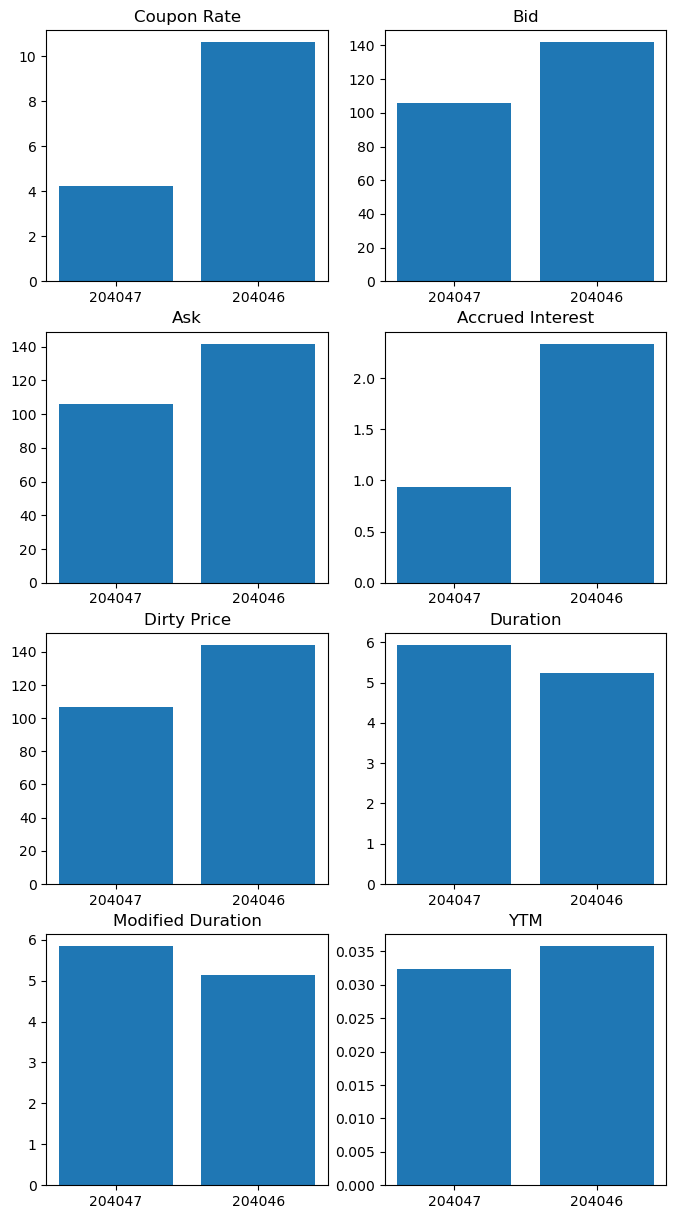

In [9]:
features = {'Coupon Rate':'tcouprt', 'Bid':'tdbid', 'Ask':'tdask', 'Accrued Interest':'tdaccint', 'Dirty Price':'dirty price', 'Duration':'duration', 'Modified Duration':'mod duration', 'YTM':'ytm'}
fig, axs = plt.subplots(4, 2, figsize=(8,15))
i = 0
for ax in axs:
    for j in [0,1]:
        title = list(features.keys())[i]
        col = features[title]
        ax[j].bar(hb1['kytreasno'].astype(str), hb1[col])
        ax[j].set_title(f"{title}")
        i+=1
    
plt.show()

#### 1.2 Hedge Ratio

In [10]:
hb1.set_index('kytreasno', inplace=True)

/Users/rahul/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [11]:
sec1, sec2 = 204046, 204047
position_value = 50_000_000
n1 = position_value/hb1.loc[sec1, 'dirty price']
n2 = -n1*hb1.loc[sec1, 'duration']/hb1.loc[sec2, 'duration']
print(f"We need to short {n2:,.0f} units of {sec2}.")

We need to short -305,495 units of 204047.


#### 1.3 Profit Opportunity
Assume the convergence is symmetric: the bond's (204046) ytm goes down 0.5bp and the note (204047) ytm goes up 0.5bp.  

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

In [12]:
sec1, sec2 = 204046, 204047
change = 0.005
change1, change2 = -change, change
price1, price2 = hb1.loc[sec1, 'dirty price'], hb1.loc[sec2, 'dirty price']

pct_change1 = - change1 * hb1.loc[sec1, 'mod duration']
pct_change2 = - change2 * hb1.loc[sec2, 'mod duration']
pnl1 = pct_change1*n1*price1
pnl2 = pct_change2*n2*price2

print(f"PnL of long position {sec1}:  ${pnl1:,.2f}")
print(f"PnL of short position {sec2}: ${pnl2:,.2f}")
print(f"PnL of total position : ${pnl1+pnl2:,.2f}")

PnL of long position 204046:  $1,284,571.06
PnL of short position 204047: $953,828.81
PnL of total position : $2,238,399.87


Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL?

In [13]:
hb1[['ytm']]

,ytm
kytreasno,
204047,0.032362
204046,0.035753


In [14]:
change = (hb1.loc[sec1, 'ytm'] - hb1.loc[sec2, 'ytm'])/2
print(f"Change of {change*10000:.1f} bps")
change1, change2 = -change, change
price1, price2 = hb1.loc[sec1, 'tdnomprc'], hb1.loc[sec2, 'tdnomprc']

pct_change1 = - change1 * hb1.loc[sec1, 'mod duration']
pct_change2 = - change2 * hb1.loc[sec2, 'mod duration']
pnl1 = pct_change1*n1*price1
pnl2 = pct_change2*n2*price2

print(f"PnL of long position {sec1}:  ${pnl1:,.2f}")
print(f"PnL of short position {sec2}: ${pnl2:,.2f}")
print(f"PnL of total position : ${pnl1+pnl2:,.2f}")

Change of 17.0 bps
PnL of long position 204046:  $428,447.10
PnL of short position 204047: $320,547.96
PnL of total position : $748,995.06


#### 1.4 Result in 2008
Calculate the profit (or loss) on the position on the following two dates:
- 2008-11-25
- 2008-12-16

In [15]:
hb2 = hb[hb['caldt'].isin(['2008-11-04', '2008-11-25', '2008-12-16'])].reset_index(drop=True)
sdf1 = hb2[hb2['kytreasno']==sec1].set_index('caldt')
sdf2 = hb2[hb2['kytreasno']==sec2].set_index('caldt')
sdf1['n'] = n1
sdf2['n'] = n2
sdf1['Value'] = sdf1['n']*sdf1['dirty price']
sdf2['Value'] = sdf2['n']*sdf2['dirty price']
sdf1['PnL'] = sdf1['Value'] - sdf1.loc['2008-11-04', 'Value']
sdf2['PnL'] = sdf2['Value'] - sdf2.loc['2008-11-04', 'Value']
show = ['kytreasno', 'ytm', 'dirty price', 'n', 'PnL']
sdf = pd.concat([sdf1[show], sdf2[show]])
sdf['PnL'] = sdf['PnL'].apply(lambda x: f"${x:,.1f}")
sdf

,kytreasno,ytm,dirty price,n,PnL
caldt,,,,,
2008-11-04,204046,0.035753,144.213655,346707.806814,$0.0
2008-11-25,204046,0.030086,148.819973,346707.806814,"$1,597,046.4"
2008-12-16,204046,0.021927,155.488791,346707.806814,"$3,909,177.6"
2008-11-04,204047,0.032362,106.904212,-305495.197132,$0.0
2008-11-25,204047,0.024787,111.990489,-305495.197132,"$-1,553,833.2"
2008-12-16,204047,0.014760,118.936141,-305495.197132,"$-3,675,696.6"


The PnLs for both securities align with YTM with both securities.
- We are long on 204046, and the YTM descreases for both dates, and we are profiting in both cases, with the 16th December havig much bigger profit compared to the 25th November which aligns with the differences in YTM.
- We are short on 204047, and the YTM decreases for both dates, and thus we are in loss in both cases, with the 16th December havig much bigger loss compared to the 25th November which aligns with the differences in YTM.

***

In [16]:
data = pd.read_excel('./data/treasury_quotes_2022-09-30.xlsx')
data.columns = data.columns.str.upper()
df = data.copy()
df = df[~df['ITYPE'].isin([11, 12])]
df.reset_index(drop=True, inplace=True)
df.sample(2)

,KYTREASNO,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
141,207311,20260131.202620,2022-09-30,94.867188,94.914062,94.890625,M,I,0.435122,-0.003275,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN
320,207889,20320515.202870,2022-09-30,92.144531,92.207031,92.175781,M,I,1.078125,-0.003506,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN


In [17]:
def get_coupon_dates(quote_date,maturity_date):
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out

def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):

    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # drop issues that had CF on excluded dates
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]

    else:
        # drop issues that have no CF on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
        
    # update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered

def calc_cashflows(quote_data, filter_maturity_dates=False):
    
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['TMATDT'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100


    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)

    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    return CF

### 2 Calculating Duration
#### 2.1
Set up the cashflow matrix

In [18]:
cashflow = calc_cashflows(df)
cashflow

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
0,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
375,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
376,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2.2
Build a discount curve assuming that the spot rate is 2% per year, continuously compounded.

In [19]:
discount = pd.DataFrame(range(31), columns=['Years'])
rate = 0.02
discount['Discount Rate'] = np.exp(-rate*discount['Years'])
# discount['Spot Rate'] = discount['Years']*np.exp((rate/discount['Years'])-1)
discount['Spot Rate'] = rate
discount.T

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Years,0.00,1.000000,2.000000,3.000000,4.000000,5.000000,6.00000,7.000000,8.000000,9.00000,...,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,30.000000
Discount Rate,1.00,0.980199,0.960789,0.941765,0.923116,0.904837,0.88692,0.869358,0.852144,0.83527,...,0.657047,0.644036,0.631284,0.618783,0.606531,0.594521,0.582748,0.571209,0.559898,0.548812
Spot Rate,0.02,0.020000,0.020000,0.020000,0.020000,0.020000,0.02000,0.020000,0.020000,0.02000,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000


Plot the discount curve and the associated spot curve out to 30 years maturity.

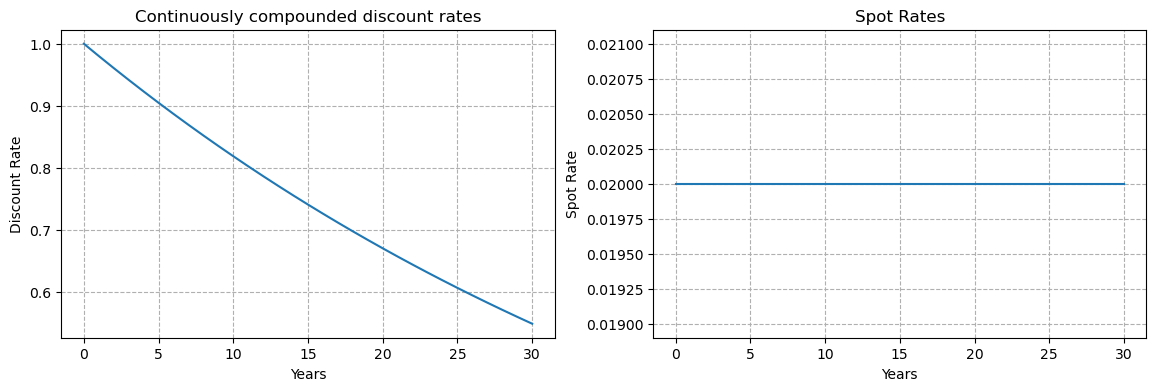

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,4))
ax1.plot(discount['Years'], discount['Discount Rate'], label='Discount Rate')
ax1.set_ylabel('Discount Rate')
ax1.set_xlabel('Years')
ax1.set_title('Continuously compounded discount rates')
ax1.grid(linestyle='--')

ax2.plot(discount['Years'], discount['Spot Rate'], label='Spot Rate')
ax2.set_ylabel('Spot Rate')
ax2.set_xlabel('Years')
ax2.set_title('Spot Rates')
ax2.grid(linestyle='--')
plt.show()

In [21]:
# Getting the time to maturity in years
df['maturity'] = (df['TMATDT'] - df['CALDT']).dt.days/YEAR

In [22]:
def duration(coupon_rate, time_to_maturity, frequency, rate):
    """
    Calculates the time intervals of the cashflows and returns the average 
    of the the time intervals weighted by the corresponding cashflows
    """
    if coupon_rate==0:
        return time_to_maturity
    else:
        first_coupon_interval = time_to_maturity%(1/frequency)
        number_of_payments = int(np.ceil(time_to_maturity/(1/frequency)))
        time_intervals = np.linspace(first_coupon_interval, time_to_maturity, number_of_payments)
        cashflows = []
        for Ti_t in time_intervals:
            cashflows.append(((coupon_rate/frequency)/np.power(1+rate/frequency, frequency*(Ti_t))))
        cashflows[-1] += 100/np.power(1+rate/frequency, frequency*time_to_maturity)
        duration = np.average(time_intervals, weights=cashflows)
        return duration

#### 2.3
For each treasury issue, calculate the duration as the weighted average of the (discounted!) cashflow maturity.

Report the summary statistics of the durations. (Use .describe() from pandas.)

In [23]:
df['duration'] = df.apply(lambda x: duration(x['TCOUPRT'], x['maturity'], x['TNIPPY'], rate), axis=1)
df[['duration']].describe()

,duration
count,378.000000
mean,5.150846
std,6.015270
min,0.010951
25%,0.882400
50%,2.751502
75%,5.991286
max,22.839487


#### 2.4
How close are your duration estimates to the imputed durations given in the data source, (column TDDURATN)?
- The differences are quite small. The average  difference in the calculation is about -0.212 with a standard deviation of -0.47.

Report the summary statistics of the imputed durations minus your calculated durations from above.

Why might they be different?
- These are different because of the rate used to calculate the discounted cashflows.

In [24]:
(df['TDDURATN']/YEAR - df['duration']).describe().to_frame('Difference')

,Difference
count,3.780000e+02
mean,-2.128958e-01
std,4.725229e-01
min,-1.968372e+00
25%,-3.393849e-02
50%,-2.061278e-03
75%,-5.223365e-07
max,4.828096e-02


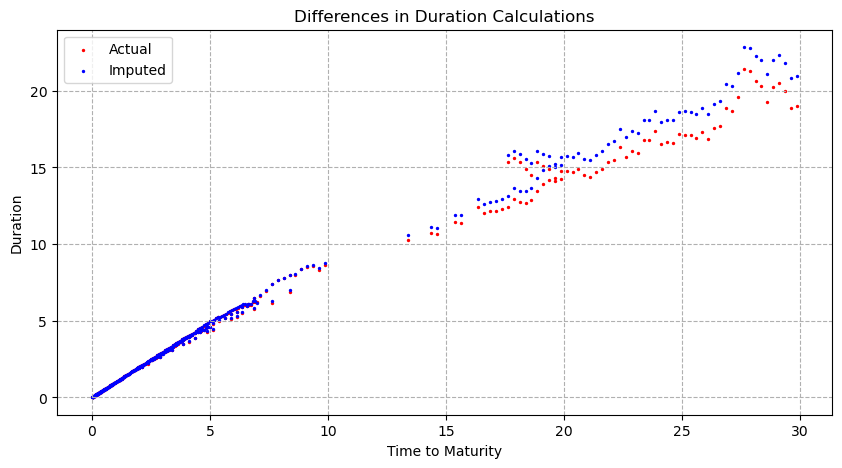

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df['maturity'], df['TDDURATN']/YEAR, color='red', s=2, label='Actual')
ax.scatter(df['maturity'], df['duration'], color='blue', s=2, label='Imputed')
ax.grid(linestyle='--')
ax.set_xlabel("Time to Maturity")
ax.set_ylabel("Duration")
ax.set_title("Differences in Duration Calculations")
ax.legend()
plt.show()

The difference is quite close for the short end of the maturity curve. However, as the time to maturity increases, the duration increases. We believe the reason behind this is the discounting factor used by CRSP versus our constant 2%. Namely, the bigger the difference in the spot rates we use to derive the discount factors, and the longer we compound those rates for, the larger the difference in duration will be. This explains why there is very little difference between the given durations and our calculations for the short end of the curve (because of much fewer compounding periods), but gets as large as 1.96 years on the long end of the curve (because of many more compounding periods).

Note, although we take the absolute value of the differences for the summary statistics, we can see that our calculated durations are higher than the imputed durations. The reason for this could be that the long end of the curve is more discounted for imputed durations than 2%, and thus decreasing the weights of payments far in the future, which causes the duration to fall.

In [26]:
def convexity(coupon_rate, time_to_maturity, frequency, rate):
    """
    Calculates the time intervals of the cashflows and returns the average 
    of the the time intervals weighted by the corresponding cashflows
    """
    if coupon_rate==0:
        return np.power(time_to_maturity,2)
    else:
        first_coupon_interval = time_to_maturity%(1/frequency)
        number_of_payments = int(np.ceil(time_to_maturity/(1/frequency)))
        time_intervals = np.linspace(first_coupon_interval, time_to_maturity, number_of_payments)
        cashflows = []
        for Ti_t in time_intervals:
            cashflows.append(((coupon_rate/frequency)/np.power(1+rate/frequency, frequency*(Ti_t))))
        cashflows[-1] += 100/np.power(1+rate/frequency, frequency*time_to_maturity)
        time_intervals_squared = np.power(time_intervals, 2)
        convexity = np.average(time_intervals_squared, weights=cashflows)
        return convexity

#### 2.5
Continue using your assumed discount rates of 2% to calculate the convexity of each issue.

Report the summary statistics of these convexity calculations.

In [27]:
df['convexity'] = df.apply(lambda x: convexity(x['TCOUPRT'], x['maturity'], x['TNIPPY'], rate), axis=1)
df[['convexity']].describe()

,convexity
count,378.000000
mean,72.803156
std,141.096260
min,0.000120
25%,0.779843
50%,7.733666
75%,37.571896
max,591.212392


### 3 Hedging Duration

Loading data

In [28]:
tsdata = pd.read_excel('./data/treasury_ts_issue_duration_(207392, 207391, 207457).xlsx', sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()
px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()
duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()

#### 3.1
Suppose you have a portfolio of 10,000 USD long in security 207391 on the last day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in 207392?

(Duration is the column TDDURATN in the raw data.)

In [29]:
portfolio_value = 10_000
sec1, sec2 = 207391, 207392

date = px.index.max()

portfolio_duration = (portfolio_value/px.loc[date, sec1])*duration.loc[date, sec1]
units_short = portfolio_duration/duration.loc[date, sec2]
print(f"Short {units_short:.1f} units of {sec2}")

Short 37.5 units of 207392


#### 3.2

Step through the time-series, doing the following:

- Starting at the end of the first day, set the hedged position according to the relative given durations.
- Use the second day's price data to evaluate the net profit or loss of the hedged position.
- Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security 207391 to be 10,000.
- Repeat throughout the timeseries.

Report

- the total profit (or loss.)
- the mean, standard deviation, min, and max of the daily profit or loss.

In [30]:
portfolio_value = 10_000
sec1, sec2 = 207391, 207392

dt = px.index.min()
qty_1 = portfolio_value/px.loc[dt, sec1]
qty_2 = qty_1*duration.loc[dt, sec1]/duration.loc[dt, sec2]
curr_value = qty_1*px.loc[dt, sec1]-qty_2*px.loc[dt, sec2]
profits = [0]

for dt in px.index[1:]:
    old_value = curr_value
    curr_value = qty_1*px.loc[dt, sec1]-qty_2*px.loc[dt, sec2]
    profit = curr_value - old_value
    profits.append(profit)
    qty_1 = portfolio_value/px.loc[dt, sec1]
    qty_2 = qty_1*duration.loc[dt, sec1]/duration.loc[dt, sec2]
    curr_value = qty_1*px.loc[dt, sec1]-qty_2*px.loc[dt, sec2]


In [31]:
pnl = pd.DataFrame(profits, index=px.index, columns=['Profit'])
total_profit = pnl['Profit'].sum()
print(f"Total Profit: ${total_profit:,.2f}")
pnl.describe()

Total Profit: $-158.60


,Profit
count,621.000000
mean,-0.255393
std,20.743553
min,-126.078548
25%,-10.391882
50%,0.000000
75%,10.794664
max,112.874402
